In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from dispatch.dispatch import Dispatch, NeuralDispatch
from simulator.base_simulator import BaseSimulator, ManualSimulator
from simulator.simulator import Simulator
from simulator.graphics import plot_CR, plot_counts
from tqdm import tqdm

import torch
from networks.encoders import PointEncoder
from networks.scoring_v1 import ScoringNet, ScoringInterface

from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector, MultiSyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from torchrl.envs import EnvBase
from tensordict.tensordict import TensorDictBase, TensorDict
from typing import Optional
import gym
from torchrl.data import CompositeSpec, BoundedTensorSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, OneHotDiscreteTensorSpec, DiscreteTensorSpec, UnboundedDiscreteTensorSpec

# import importlib
# importlib.reload(utils)

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 200_000 // frame_skip

sub_batch_size = 4  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

cpu


In [3]:
net = ScoringNet(
    mode='default',
    # point_encoder=point_encoder,
    n_layers=2,
    d_model=512,
    n_head=4,
    dim_ff=512,
    point_enc_dim=64,
    number_enc_dim=8,
    device=device
)

model = ScoringInterface(net)
# model.load_weights('pretrained_models/assignment_cloning_model_v2')

In [4]:
bounds = (Point(0, 0), Point(10, 10))
triples = [random_triple(bounds) for _ in range(sub_batch_size)]

model.encode_input(triples, 0)
preds = model.inference()
mask = model.get_mask()

print(preds.shape, mask.shape)

torch.Size([4, 10, 7]) torch.Size([4, 10, 6])


In [5]:
optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-4, momentum=0.9) # FIX unfreeze encoder params
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=n_iters)
scheduler = None

losses = []
for epoch in range(2):
    for iter in range(10):
        rolling_loss = []
        triples = [random_triple(bounds) for _ in range(sub_batch_size)]

        scorer = ETAScoring()
        solver = HungarianSolver()
        assignments = []
        for triple in triples:
            scores = scorer(triple.orders, triple.couriers)
            assignments.append([(i, j) for i, j in zip(*solver(scores))])

        # print(assignments)
        # print(50 * '-')

        optimizer.zero_grad()
        model.encode_input(triples, 0)
        model.inference()
        loss = model.CE_loss(assignments)
        loss.backward()
        optimizer.step()
        rolling_loss.append(loss.item())

    losses.append(np.mean(rolling_loss))

    print(losses)

[14.724509239196777]
[14.724509239196777, 50.051822662353516]


100%|██████████| 1000/1000 [00:00<00:00, 4105.78it/s]


micro average CR:  0.7014350306746223
macro average CR:  0.6967960252894781


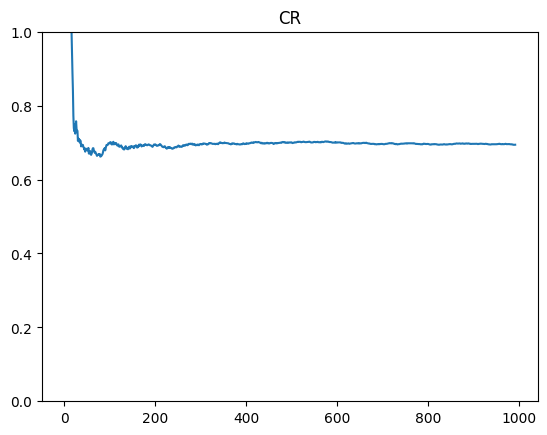

average free couriers:  1.503
average free orders:  12.986
average active routes:  18.497


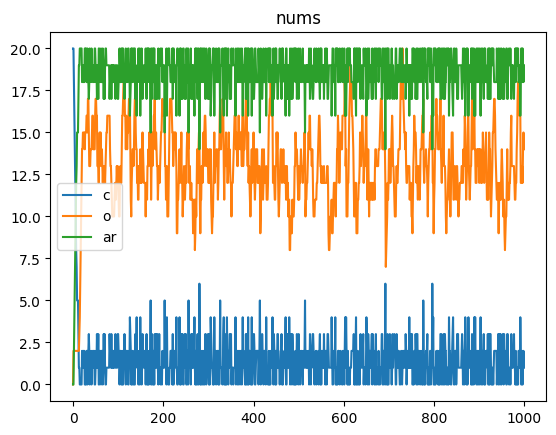

In [6]:
# dsp = NeuralDispatch(net)
dsp = Dispatch()
sim = Simulator()

all_metrics = []
for i in tqdm(range(1000)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    state = sim.GetState()
    sim.Next(dsp(state))

plot_CR(all_metrics)
plot_counts(all_metrics)

In [7]:
# # dsp = NeuralDispatch(net)
# dsp = Dispatch()
# sim = ManualSimulator()

# all_metrics = []
# for i in tqdm(range(1000)):
#     metrics = sim.GetMetrics()
#     all_metrics.append(metrics)
#     ass = dsp(sim.GetState())
#     sim.Next(ass)

# plot_CR(all_metrics)
# plot_counts(all_metrics)

In [8]:
# model.tensors['o'].shape
model.values.shape

torch.Size([4, 9])

In [9]:
class SimulatorEnv(EnvBase):
    def __init__(self, simulator: type[Simulator], model: ScoringInterface, seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[sub_batch_size])
        self.simulators = [simulator(seed=i) for i in range(sub_batch_size)]
        self.model = model
        # self.simulator.reset()
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)
        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        '''
        tensordict['action'] - a np.array of indexes of couriers assigned for the given order. If there is no courier assigned -1 is provided.
        '''
        # self.simulator.Next([(o_ind, c_ind) for o_ind, c_ind in enumerate(tensordict['action']) if c_ind != -1])
        states = [simulator.GetState() for simulator in self.simulators]
        self.model.encode_input(states, 0)
        self.model.inference()
        assignments_batch = self.model.get_assignments_batch(states)
        # self.ass = assignments_batch
        rewards = []
        for assignments, simulator in zip(assignments_batch, self.simulators):
            simulator.Next(assignments)
            rewards.append(0)
        # reward = self.simulator.GetReward()
        done = False

        out = TensorDict(
            {
                "next": {
                    "observation": {
                        'tensors': {
                            'o': self.model.tensors['o'],
                            'c': self.model.tensors['c'],
                            'ar': self.model.tensors['ar']     
                        },
                        'masks': {
                            'o': self.model.masks['o'],
                            'c': self.model.masks['c'],
                            'ar': self.model.masks['ar']     
                        }
                        # 'orders': self.model.tensors['o'],
                        # 'couriers': self.model.tensors['c'],
                        # 'active_routes': self.model.tensors['ar'] 
                    },
                    "reward": torch.tensor(rewards, dtype=torch.float32),
                    "done": torch.tensor([False] * sub_batch_size, dtype=torch.bool),
                }
            },
            batch_size=[sub_batch_size]
            # batch_size=tensordict.shape[0]
            # tensordict.shape,
        )
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            return TensorDict(
            {
                "observation": {
                    'tensors': {
                        'o': self.model.tensors['o'],
                        'c': self.model.tensors['c'],
                        'ar': self.model.tensors['ar']     
                    },
                    'masks': {
                        'o': self.model.masks['o'],
                        'c': self.model.masks['c'],
                        'ar': self.model.masks['ar']     
                    }
                        # 'orders': self.model.tensors['o'],
                        # 'couriers': self.model.tensors['c'],
                        # 'active_routes': self.model.tensors['ar'] 
                }
            },
            # batch_size=(16,),
            # batch_size=(self.model.tensors['o'].shape[0],),
            batch_size=[sub_batch_size]
        ) 
        return tensordict
        # return TensorDict(
        #     {
        #         "observation": tensordict['observation'],
        #     },
        #     # batch_size=tensordict.shape[0],
        # )
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = UnboundedDiscreteTensorSpec(
            dtype=torch.int,
            shape=[sub_batch_size]
            # shape=(1,)
            # shape=(self.model.tensors['o'].shape[0],)
        )
        observation_spec = CompositeSpec(
            tensors = CompositeSpec(
                o = DiscreteTensorSpec(
                    n=2,
                    shape=[sub_batch_size],
                    dtype=torch.float
                ),
                c = DiscreteTensorSpec(
                    n=2,
                    shape=[sub_batch_size],
                    dtype=torch.float
                ),
                ar = DiscreteTensorSpec(
                    n=2,
                    shape=[sub_batch_size],
                    dtype=torch.float
                ),
                shape=[sub_batch_size]
            ),
            masks = CompositeSpec(
                o = UnboundedContinuousTensorSpec(
                    dtype=torch.bool,
                    shape=[sub_batch_size]
                ),
                c = UnboundedContinuousTensorSpec(
                    dtype=torch.bool,
                    shape=[sub_batch_size]
                ),
                ar = UnboundedContinuousTensorSpec(
                    dtype=torch.bool,
                    shape=[sub_batch_size]
                ),
                shape=[sub_batch_size]
            ),
            # orders = UnboundedContinuousTensorSpec(
            #     dtype=torch.float32,
            #     shape=[sub_batch_size]
            # ),
            # couriers = UnboundedContinuousTensorSpec(
            #     dtype=torch.float32,
            #     shape=[sub_batch_size]
            # ),
            # active_routes = UnboundedContinuousTensorSpec(
            #     dtype=torch.float32,
            #     shape=[sub_batch_size]
            # ),
            shape=[sub_batch_size]
        )
        # if not isinstance(observation_spec, CompositeSpec):
        observation_spec = CompositeSpec(observation=observation_spec, shape=[sub_batch_size])
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            shape=[sub_batch_size],
            dtype=torch.float32,
        )
        self.done_spec = BinaryDiscreteTensorSpec(
            sub_batch_size,
            shape=[sub_batch_size]
        )
 

In [10]:
my_env = SimulatorEnv(Simulator, model)

In [11]:
env = TransformedEnv(
    my_env,
    # Compose(
    #     # normalize observations
    #     # ObservationNorm(in_keys=["observation"]),
    #     # DoubleToFloat(in_keys=["observation"]),
    #     StepCounter(),
    # ),
)

In [12]:
# env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
# print("normalization constant shape:", env.transform[0].loc.shape)
print("observation_spec:", my_env.observation_spec)
print("reward_spec:", my_env.reward_spec)
print("input_spec:", my_env.input_spec)
print("action_spec (as defined by input_spec):", my_env.action_spec)

observation_spec: CompositeSpec(
    observation: CompositeSpec(
        tensors: CompositeSpec(
            o: DiscreteTensorSpec(
                 shape=torch.Size([4]), space=DiscreteBox(n=2), device=cpu, dtype=torch.float32, domain=discrete),
            c: DiscreteTensorSpec(
                 shape=torch.Size([4]), space=DiscreteBox(n=2), device=cpu, dtype=torch.float32, domain=discrete),
            ar: DiscreteTensorSpec(
                 shape=torch.Size([4]), space=DiscreteBox(n=2), device=cpu, dtype=torch.float32, domain=discrete), device=cpu, shape=torch.Size([4])),
        masks: CompositeSpec(
            o: UnboundedContinuousTensorSpec(
                 shape=torch.Size([4]), space=None, device=cpu, dtype=torch.bool, domain=continuous),
            c: UnboundedContinuousTensorSpec(
                 shape=torch.Size([4]), space=None, device=cpu, dtype=torch.bool, domain=continuous),
            ar: UnboundedContinuousTensorSpec(
                 shape=torch.Size([4]), spa

In [13]:
# check_env_specs(env, return_contiguous=False)

In [14]:
rollout = my_env.rollout(10, return_contiguous=False)
# print("rollout of three steps:", rollout)
# print("Shape of the rollout TensorDict:", rollout.batch_size)

In [15]:
rollout.batch_size

torch.Size([4, 10])

In [16]:
policy_module = TensorDictModule(
    net, in_keys=[('observation', 'tensors'), ('observation', 'masks')], out_keys=['logits', 'values']
)

In [17]:
print("Running policy:", policy_module(my_env.reset()))
# env.reset()

Running policy: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False),
        logits: Tensor(shape=torch.Size([4, 17, 20]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: TensorDict(
            fields={
                masks: TensorDict(
                    fields={
                        ar: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                        c: Tensor(shape=torch.Size([4, 19]), device=cpu, dtype=torch.bool, is_shared=False),
                        o: Tensor(shape=torch.Size([4, 17]), device=cpu, dtype=torch.bool, is_shared=False)},
                    batch_size=torch.Size([4]),
                    device=cpu,
                    is_shared=False),
                tensors: TensorDict(
                    fields={
                        ar: Tensor(shape=torch.Size([4, 1, 512]), device=cpu, dtype=torch.float32, is_shared=False),
              

In [18]:
# for i in [0, 1, 2, 3]:
#     print(my_env.simulators[i].GetMetrics())
#     print('-'* 50)


In [19]:
# from tensordict.nn.distributions import Categorical
from torch.distributions.categorical import Categorical
policy_module_actor = ProbabilisticActor(
    module=policy_module,
    in_keys=["logits"],
    distribution_class=Categorical,
    # distribution_kwargs={
    #     "n": env.action_spec.space.n,
    # },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [20]:
# value_module = ValueOperator(
#     module=net,
#     in_keys=[('observation', 'tensors'), ('observation', 'masks')], 
#     out_keys=['logits', 'values']
# )


In [21]:
collector = SyncDataCollector(
    my_env,
    policy_module_actor,
    frames_per_batch=1,
    total_frames=5,
    split_trajs=False,
    device=device,
)

AssertionError: query should be unbatched 2D or batched 3D tensor but received 1-D query tensor

## Testing area

In [19]:
bs = 2

class TestEnv(EnvBase):
    def __init__(self, seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[bs])
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)
        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        '''
        tensordict['action'] - a np.array of indexes of couriers assigned for the given order. If there is no courier assigned -1 is provided.
        '''
        print('next')
        out = TensorDict(
            {
                "next": {
                    "observation": TensorDict({
                        'a': torch.tensor([[-1, -2], [-4, -5]], dtype=torch.float),
                        'b': torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float),
                        },
                        batch_size=[bs]
                    ),
                    "reward": torch.tensor([0] * bs, dtype=torch.float32),
                    "done": torch.tensor([False] * bs, dtype=torch.bool),
                }
            },
            batch_size=[bs]
        )
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            return TensorDict(
            {
                "observation": TensorDict({
                        'a': torch.tensor([[-1, -2], [-4, -5]], dtype=torch.float),
                        'b': torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float),
                        },
                        batch_size=[bs]
                    ),
            },
            batch_size=[bs]
        ) 
        return tensordict
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = UnboundedDiscreteTensorSpec(
            dtype=torch.int,
            shape=[bs]
            # shape=(1,)
            # shape=(self.model.tensors['o'].shape[0],)
        )
        observation_spec = CompositeSpec(
            a = UnboundedContinuousTensorSpec(
                dtype=torch.float32,
                shape=[bs]
            ),
            b = UnboundedContinuousTensorSpec(
                dtype=torch.float32,
                shape=[bs]
            ),
            shape=[bs]
        )
        # if not isinstance(observation_spec, CompositeSpec):
        observation_spec = CompositeSpec(observation=observation_spec, shape=[bs])
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            shape=[bs],
            dtype=torch.float32,
        )
        self.done_spec = BinaryDiscreteTensorSpec(
            bs,
            shape=[bs]
        )
 

In [20]:
env = TransformedEnv(
    TestEnv(),
    # Compose(
    #     # normalize observations
    #     # ObservationNorm(in_keys=["observation"]),
    #     # DoubleToFloat(in_keys=["observation"]),
    #     StepCounter(),
    # ),
)

In [21]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

check_env_specs(env)

observation_spec: CompositeSpec(
    observation: CompositeSpec(
        a: UnboundedContinuousTensorSpec(
             shape=torch.Size([2, 3]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
        b: UnboundedContinuousTensorSpec(
             shape=torch.Size([2, 3]), space=None, device=cpu, dtype=torch.float32, domain=continuous), device=cpu, shape=torch.Size([2, 3])), device=cpu, shape=torch.Size([2]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([2]), space=None, device=cpu, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: UnboundedDiscreteTensorSpec(
         shape=torch.Size([2]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, contiguous=True)), device=cpu, dtype=torch.int32, domain=continuous), device=cpu, shape=torch.Size([2]))
action_spec (as defined by input_spec): UnboundedDis

AssertionError: The dtypes of the real and fake tensordict don't match for key next.done. Got fake=torch.int64 and real=torch.bool.

In [89]:
fake = env.fake_tensordict().flatten_keys(".")
print(fake)

real_tensordict = env.rollout(3, return_contiguous=True).flatten_keys(".")
print(real_tensordict)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        next.done: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        next.observation.a: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        next.observation.b: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        next.reward: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.a: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.b: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=F

In [91]:
fake_tensordict = fake.unsqueeze(real_tensordict.batch_dims - 1).expand(*real_tensordict.shape).to_tensordict()

In [93]:
# real_tensordict.apply(lambda x: torch.zeros_like(x)) == fake_tensordict.apply(lambda x: torch.zeros_like(x))
# fake_tensordict
fake_tensordict

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        next.done: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        next.observation.a: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next.observation.b: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next.reward: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.a: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.b: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2, 3]),
 

In [131]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.f1 = nn.Linear(3, 5)
        self.f2 = nn.Linear(3, 5)

        self.last = nn.Linear(5, 2)
    
    def forward(self, x, y):
        x = self.f1(x)
        y = self.f2(y)

        return self.last(x - y)

In [137]:
x = torch.tensor([[1, 2, 3]], dtype=torch.float)
y = torch.tensor([[1, 2, 3]], dtype=torch.float)
n = Net()
n(x, y)

tensor([[-1.7460, -0.8222]], grad_fn=<AddmmBackward0>)

In [138]:
policy_module = TensorDictModule(
    n, in_keys=[('inp', "x"), ('inp', "y")], out_keys=["out"]
)

In [146]:
# policy_module(x=x, y=y)
inp = TensorDict(
    {
        'inp': TensorDict({
            'x': x,
            'y': y,
        }, batch_size=())
    },
    batch_size=(1, 3)
)

In [140]:
out = policy_module(inp)

In [23]:
out['out']

tensor([1.9481, 0.0790], grad_fn=<AddBackward0>)

In [147]:
inp.shape

torch.Size([1, 3])